# Correlation regarding the Children to Teachers Ratio


In [90]:
from school_analysis.preprocessing.helpers.students_teachers import combine_school_type
from school_analysis.preprocessing.load import Loader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tueplots.constants.color import rgb
import school_analysis as sa
from school_analysis.plotting.general import GeneralPlots
from school_analysis.preprocessing import SCHOOL_TYPE_MAPPING

loader = Loader()

# Budgets
budget = loader.load("budgets-corrected")

# Grades
grades = loader.load("abi-grades")
grades_temp = grades.T.reset_index().rename(
    columns={"level_0": "Federal State", "level_1": "Year"})
grades = pd.melt(grades_temp, id_vars=[
                 "Federal State", "Year"], value_vars=grades_temp.columns[2:], value_name="Value")
grades["Federal State"] = grades["Federal State"].map(sa.STATE_MAPPING)
grades["Year"] = grades["Year"].astype(int)
grades["Grade"] = grades["Grade"].astype(float)

# Repeaters
repeaters = loader.load("number_of_repeaters")
repeaters = repeaters.rename(columns={"state": "Federal State", "school": "School Type",
                             "year": "Year", "total": "Repeaters", "grade": "Grade"}).drop(columns=["male", "female"])
repeaters["Repeaters"] = repeaters["Repeaters"].replace(
    "-", np.nan).dropna().astype(int)

# Teachers to Students
teachers_students_state = loader.load("students-per-teacher-by-state")
teachers_students_state = teachers_students_state.dropna().drop_duplicates()
teachers_students_type = loader.load("students-per-teacher-by-type")
teachers_students_type = teachers_students_type.dropna().drop_duplicates()

# Pisa
pisa = loader.load("pisa-germany")

## Teachers to Students Ratio vs. Grades


In [31]:
# Get data
ts_state_c = teachers_students_state.copy()
ts_type_c = teachers_students_type.copy()
grades_c = grades.copy()

# Filter the data to only required cols
ts_state_c = ts_state_c[ts_state_c["Type"] == "Pupils"][[
    "Federal State", "Year", "Students per Teacher"]].drop_duplicates()
ts_state_avg = ts_state_c.groupby(["Year"]).apply(lambda x: x["Students per Teacher"].mean(
)).reset_index().rename(columns={0: "Students per Teacher"})

grades_c["Grade"] = grades_c["Grade"]
avg_grade_state = grades_c.groupby(["Federal State", "Year"]).apply(lambda x: (
    x["Grade"] * x["Value"]).sum() / x["Value"].sum()).reset_index().rename(columns={0: "Average Grade"})
avg_grade = grades_c.groupby(["Year"]).apply(lambda x: (
    x["Grade"] * x["Value"]).sum() / x["Value"].sum()).reset_index().rename(columns={0: "Average Grade"})

In [32]:
grade_ts_state = pd.merge(ts_state_c, avg_grade_state,
                          on=["Federal State", "Year"])
grade_ts_state_avg = pd.merge(ts_state_avg, avg_grade, on=["Year"])

print("Corr [TS, Grade] by State: ", np.corrcoef(
    grade_ts_state["Students per Teacher"], grade_ts_state["Average Grade"])[0][1])
print("Corr [TS, Grade] by Avg over all States: ", np.corrcoef(
    grade_ts_state_avg["Students per Teacher"], grade_ts_state_avg["Average Grade"])[0][1])

Corr [TS, Grade] by State:  0.3555832254922997
Corr [TS, Grade] by Avg over all States:  0.9015207901020657


In [33]:
grade_ts_state_avg

,Year,Students per Teacher,Average Grade
0,2007,11.876377,2.530665
1,2008,11.674574,2.523515
2,2009,11.421269,2.517675
3,2010,11.303607,2.500708
4,2011,11.329358,2.498626
5,2012,11.326305,2.472224
6,2013,11.342102,2.459223
7,2014,11.320906,2.456677
8,2015,11.252558,2.454814
9,2016,11.220105,2.435339


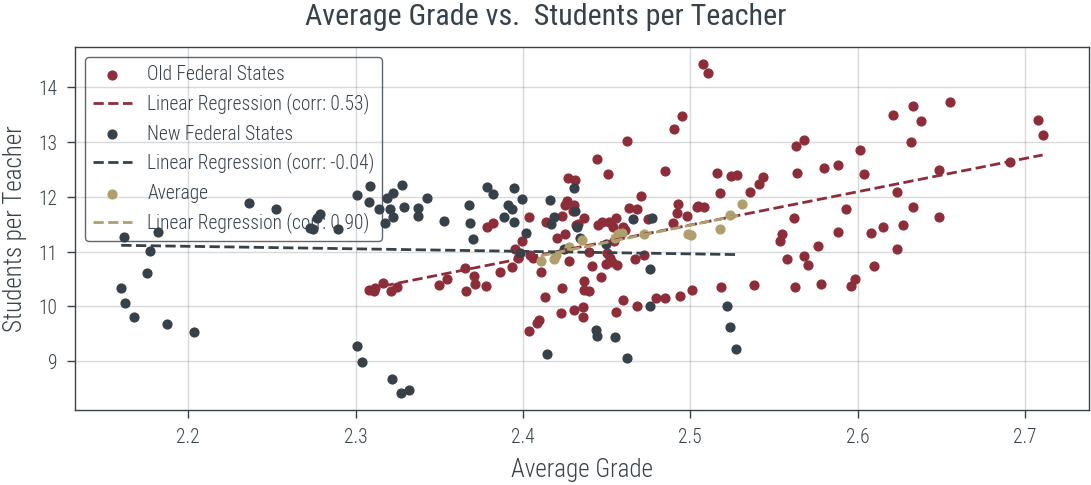

In [34]:
GeneralPlots.federal_state_corr_plot(
    grade_ts_state,
    "Students per Teacher",
    "Average Grade",
    melted_df=grade_ts_state_avg,
)

Generate a table of the correlations between the teachers to students ratio and the grades of the students for each federal state.


In [35]:
from tabulate import tabulate

result = []
for state in grade_ts_state["Federal State"].unique():
    state_data_grade = grade_ts_state[grade_ts_state["Federal State"] == state]
    corr = {}

    # Get corr
    corr["state"] = state
    corr["Avg. Grade - Students per Teacher"] = np.corrcoef(
        state_data_grade["Students per Teacher"], state_data_grade["Average Grade"])[0][1]
    corr["Type"] = "New" if state in sa.NEW_OLD_STATES_MAPPING["New Federal States"] else "Old"
    result.append(corr)

# Sort results
sorted_result = sorted(result, key=lambda x: x['Type'])

print(tabulate(sorted_result, headers="keys"))

state                     Avg. Grade - Students per Teacher  Type
----------------------  -----------------------------------  ------
Brandenburg                                      0.0649284   New
Mecklenburg-Vorpommern                          -0.00162331  New
Sachsen                                         -0.756182    New
Sachsen-Anhalt                                  -0.777764    New
Thüringen                                       -0.849959    New
Baden-Württemberg                               -0.686881    Old
Bayern                                           0.904998    Old
Bremen                                           0.743569    Old
Hamburg                                          0.937676    Old
Hessen                                           0.819669    Old
Niedersachsen                                    0.945662    Old
Nordrhein-Westfalen                              0.968521    Old
Rheinland-Pfalz                                  0.787819    Old
Saarland             

## Correlation between the teachers to students ratio and the budget per student


In [36]:
# Get data
ts_state_c = teachers_students_state.copy()
ts_type_c = teachers_students_type.copy()
budget_c = budget.copy()

# Filter the data to only required cols
ts_state_c = ts_state_c[ts_state_c["Type"] == "Pupils"][[
    "Federal State", "Year", "Students per Teacher"]].drop_duplicates()
ts_state_avg = ts_state_c.groupby(["Year"]).apply(lambda x: x["Students per Teacher"].mean(
)).reset_index().rename(columns={0: "Students per Teacher"})

budget_c = budget_c.drop(columns=["Year Relative", "Index"])
budget_c_avg = budget_c.groupby(["Year"]).apply(lambda x: x["Reference Budget"].mean(
)).reset_index().rename(columns={0: "Reference Budget"})

In [37]:
ts_budget_state = pd.merge(ts_state_c, budget_c, on=[
                           "Federal State", "Year"]).dropna().drop_duplicates()
ts_budget_state_avg = pd.merge(ts_state_avg, budget_c_avg, on=[
                               "Year"]).dropna().drop_duplicates()

print("Corr [TS, Budget] by State: ", np.corrcoef(
    ts_budget_state["Students per Teacher"], ts_budget_state["Reference Budget"])[0][1])
print("Corr [TS, Budget] by Avg over all States: ", np.corrcoef(
    ts_budget_state_avg["Students per Teacher"], ts_budget_state_avg["Reference Budget"])[0][1])

Corr [TS, Budget] by State:  -0.48802900700183954
Corr [TS, Budget] by Avg over all States:  -0.9580021395168237


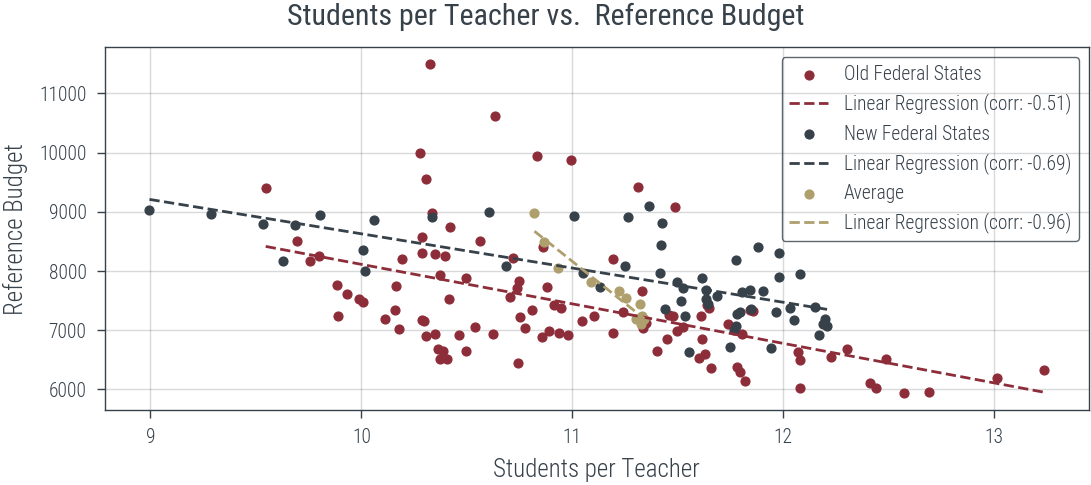

In [38]:
GeneralPlots.federal_state_corr_plot(
    ts_budget_state,
    "Reference Budget",
    "Students per Teacher",
    melted_df=ts_budget_state_avg,
)

## Correlation between the teachers to students ratio and the repeater rate


In [39]:
# Get data
ts_state_c = teachers_students_state.copy()
ts_type_c = teachers_students_type.copy()
repeaters_c = repeaters.copy()

# Filter the data to only required cols
ts_state_c = ts_state_c[ts_state_c["Type"] == "Pupils"][[
    "Federal State", "Year", "Students per Teacher"]].drop_duplicates()
ts_state_avg = ts_state_c.groupby(["Year"]).apply(lambda x: x["Students per Teacher"].mean(
)).reset_index().rename(columns={0: "Students per Teacher"})

repeaters_state = repeaters_c.groupby(["Federal State", "Year"]).apply(
    lambda x: x["Repeaters"].mean()).reset_index().rename(columns={0: "Repeaters"})
repeaters_avg = repeaters_c.groupby(["Year"]).apply(
    lambda x: x["Repeaters"].mean()).reset_index().rename(columns={0: "Repeaters"})

In [40]:
ts_repeaters_state = pd.merge(ts_state_c, repeaters_state, on=[
                              "Federal State", "Year"]).dropna().drop_duplicates()
ts_repeaters_state_avg = pd.merge(ts_state_avg, repeaters_avg, on=[
                                  "Year"]).dropna().drop_duplicates()

print("Corr [TS, Repeaters] by State: ", np.corrcoef(
    ts_repeaters_state["Students per Teacher"], ts_repeaters_state["Repeaters"])[0][1])
print("Corr [TS, Repeaters] by Avg over all States: ", np.corrcoef(
    ts_repeaters_state_avg["Students per Teacher"], ts_repeaters_state_avg["Repeaters"])[0][1])

Corr [TS, Repeaters] by State:  0.5239656038909541
Corr [TS, Repeaters] by Avg over all States:  0.9595752257303714


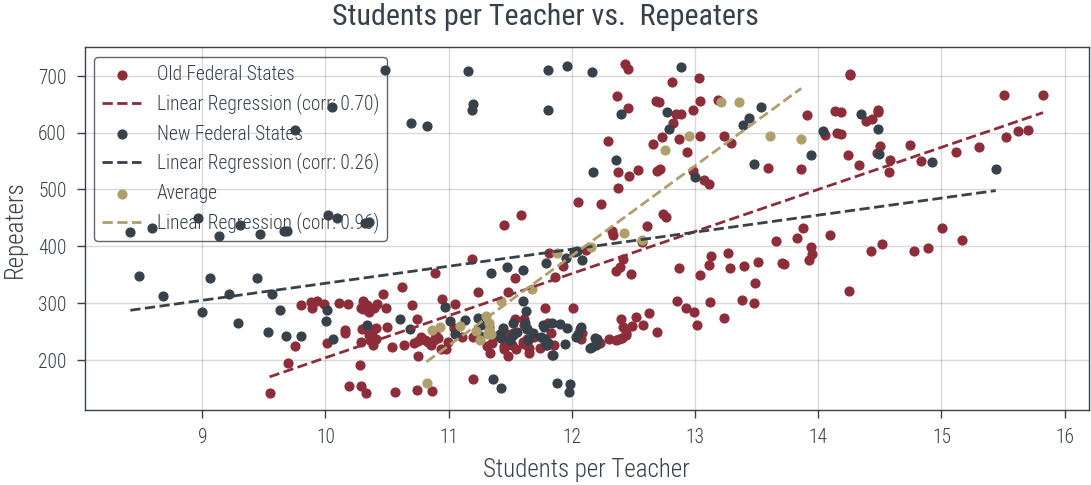

In [41]:
GeneralPlots.federal_state_corr_plot(
    ts_repeaters_state,
    "Repeaters",
    "Students per Teacher",
    melted_df=ts_repeaters_state_avg,
)

## Correlation between the teachers to students ratio and the repeater by school type


In [42]:
# Get data
ts_type_c = teachers_students_type.copy()
repeaters_c = repeaters.copy()
repeaters_c["School Type"] = repeaters_c["School Type"].map(
    SCHOOL_TYPE_MAPPING)
repeaters_c = combine_school_type(
    repeaters_c, "School Type", "Repeaters", new_type="Gymnasien")
repeaters_c = repeaters_c.dropna().drop_duplicates()

# Filter the data to only required cols
ts_type_c = ts_type_c[["School Type", "Year",
                       "Students per Teacher"]].drop_duplicates()
ts_type_avg = ts_type_c.groupby(["Year"]).apply(lambda x: x["Students per Teacher"].mean(
)).reset_index().rename(columns={0: "Students per Teacher"})

repeaters_type = repeaters_c.groupby(["School Type", "Year"]).apply(
    lambda x: x["Repeaters"].mean()).reset_index().rename(columns={0: "Repeaters"})
repeaters_avg = repeaters_c.groupby(["Year"]).apply(
    lambda x: x["Repeaters"].mean()).reset_index().rename(columns={0: "Repeaters"})

In [43]:
ts_repeaters_type = pd.merge(ts_type_c, repeaters_type, on=[
                             "School Type", "Year"]).dropna().drop_duplicates()
ts_repeaters_type_avg = pd.merge(ts_type_avg, repeaters_avg, on=[
                                 "Year"]).dropna().drop_duplicates()

print("Corr [TS, Repeaters] by Type: ", np.corrcoef(
    ts_repeaters_type["Students per Teacher"], ts_repeaters_type["Repeaters"])[0][1])
print("Corr [TS, Repeaters] by Avg over all Types: ", np.corrcoef(
    ts_repeaters_type_avg["Students per Teacher"], ts_repeaters_type_avg["Repeaters"])[0][1])

Corr [TS, Repeaters] by Type:  -0.4194912222181848
Corr [TS, Repeaters] by Avg over all Types:  -0.004011487206380881


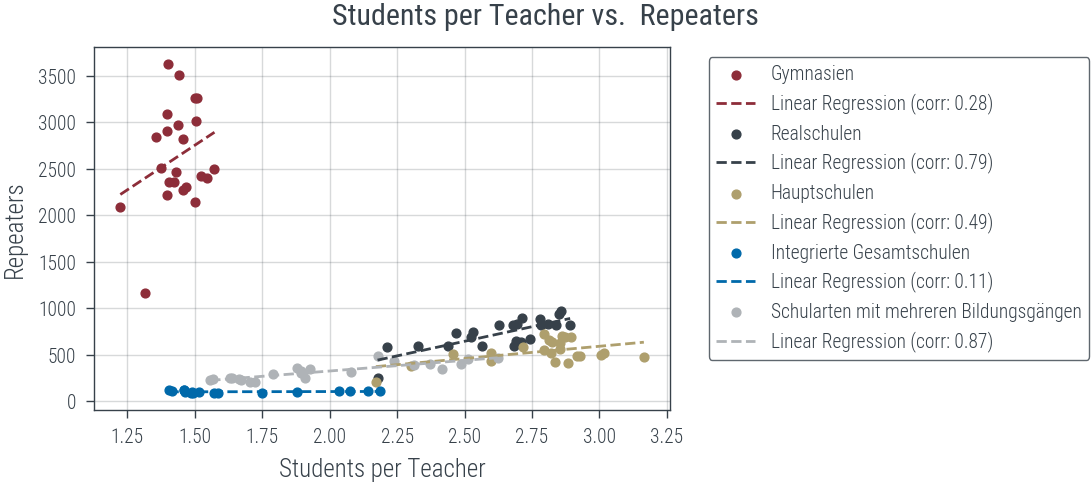

In [44]:
from school_analysis.preprocessing.helpers.students_teachers import get_most_common_school_types


GeneralPlots.school_type_corr_plot(
    ts_repeaters_type,
    "Repeaters",
    "Students per Teacher",
    school_types=get_most_common_school_types(
        teachers_students_type, 5, school_type_col="School Type", value_col="Students"),
    avg=False
)

In [45]:
ts_repeaters_type["School Type"].unique()

array(['Gymnasien', 'Hauptschulen', 'Realschulen',
       'Schularten mit mehreren Bildungsgängen',
       'Integrierte Gesamtschulen'], dtype=object)

## Teachers to Students Ratio vs. Pisa


In [93]:
pisa

,Year,Jurisdiction,Subject,Value,Measure,Type
12,2003,International Average (OECD),math,499.463525,avg,all
13,2003,Germany,math,502.985533,avg,all
28,2003,International Average (OECD),math,0.552362,std,all
29,2003,Germany,math,3.317209,std,all
172,2003,International Average (OECD),read,494.085966,avg,all
...,...,...,...,...,...,...
259,2022,Germany,read,3.360647,std,repeated never
396,2022,International Average (OECD),science,492.793006,avg,repeated never
397,2022,Germany,science,514.216343,avg,repeated never
412,2022,International Average (OECD),science,0.439850,std,repeated never


In [97]:
pisa_c = pisa.copy()
ts_state_c = teachers_students_state.copy()

# Filter the data to only required cols
pisa_c = pisa_c[(pisa_c["Jurisdiction"] == "Germany") & (
    pisa_c["Measure"] == "avg") & (pisa_c["Type"] == "all")].drop(columns=["Jurisdiction", "Measure", "Type"]).drop_duplicates()

ts_state_c = ts_state_c.groupby(["Year"]).apply(lambda x: x["Students per Teacher"].mean(
)).reset_index().rename(columns={0: "Students per Teacher"})

In [103]:
# Merge
pisa_ts = pd.merge(pisa_c, ts_state_c, on=["Year"]).dropna().drop_duplicates()

print("Corr [TS, PISA] by State: ", np.corrcoef(
    pisa_ts["Value"], pisa_ts["Students per Teacher"])[0][1])

Corr [TS, PISA] by State:  -0.2848086292483275


Text(0.5, 0.98, 'Correlation between Students per Teacher and PISA Score')

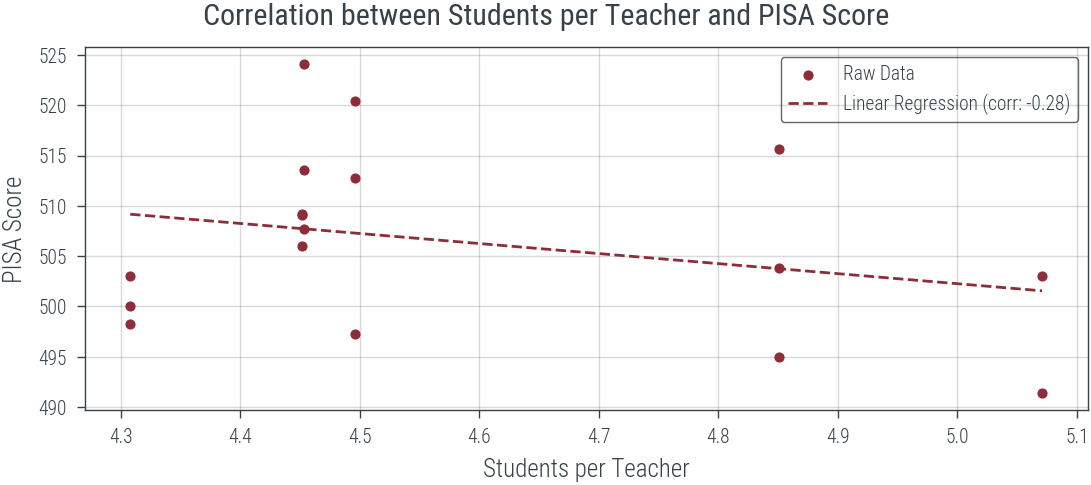

In [113]:
fig, ax = plt.subplots(1, 1)

ax.scatter(
    pisa_ts["Students per Teacher"],
    pisa_ts["Value"],
    s=10,
    label="Raw Data"
)

# Linear regression
corr = np.corrcoef(pisa_ts["Students per Teacher"], pisa_ts["Value"])[0][1]
X = np.vstack([np.ones(len(pisa_ts["Students per Teacher"])),

              pisa_ts["Students per Teacher"]]).T
y = pisa_ts["Value"]
w, res, _, _ = np.linalg.lstsq(X, y, rcond=None)
minimum = pisa_ts["Students per Teacher"].min()
maximum = pisa_ts["Students per Teacher"].max()
xp = np.linspace(minimum, maximum, int(abs(maximum - minimum) * 100))
ax.plot(
    xp,
    w[0] + w[1] * xp,
    "--",
    label="Linear Regression (corr: {:.2f})".format(corr)
)

ax.grid(True)
ax.legend()
ax.set_xlabel("Students per Teacher")
ax.set_ylabel("PISA Score")
fig.suptitle("Correlation between Students per Teacher and PISA Score")

## Correlation table for each federal state and the teachers to students ratio


In [46]:
def correlation(data_frame: pd.DataFrame, col1: str, col2: str) -> float:
    return np.corrcoef(data_frame[col1], data_frame[col2])[0][1]

In [50]:
from tabulate import tabulate

result = []
for state in grade_ts_state["Federal State"].unique():
    state_data_grade = grade_ts_state[grade_ts_state["Federal State"] == state]
    state_data_budget = ts_budget_state[ts_budget_state["Federal State"] == state]
    state_data_repeaters = ts_repeaters_state[ts_repeaters_state["Federal State"] == state]
    corr = {}
    # Get corr
    corr["Avg. Grade"] = correlation(
        state_data_grade, "Students per Teacher", "Average Grade")
    corr["Budget"] = correlation(
        state_data_budget, "Students per Teacher", "Reference Budget")
    corr["Repeaters"] = correlation(
        state_data_repeaters, "Students per Teacher", "Repeaters")

    # Meta
    corr["state"] = state
    corr["Type"] = "New" if state in sa.NEW_OLD_STATES_MAPPING["New Federal States"] else "Old"
    result.append(corr)

result = pd.DataFrame(result).sort_values(
    by=["Type", "Avg. Grade"], ascending=False)
result

,Avg. Grade,Budget,Repeaters,state,Type
10,0.969178,-0.932571,0.871230,Saarland,Old
8,0.968521,-0.946145,0.885857,Nordrhein-Westfalen,Old
7,0.945662,-0.841132,0.909775,Niedersachsen,Old
4,0.937676,-0.975152,0.756125,Hamburg,Old
1,0.904998,-0.782802,0.898745,Bayern,Old
5,0.819669,-0.870350,0.931542,Hessen,Old
9,0.787819,-0.759301,0.961141,Rheinland-Pfalz,Old
3,0.743569,-0.878366,0.859825,Bremen,Old
13,0.639872,-0.973672,0.875805,Schleswig-Holstein,Old
0,-0.686881,-0.843531,0.944432,Baden-Württemberg,Old


Now we want to create a bar chart for each federal state that shows the correlation between the teachers to students ratio and the grades of the students.


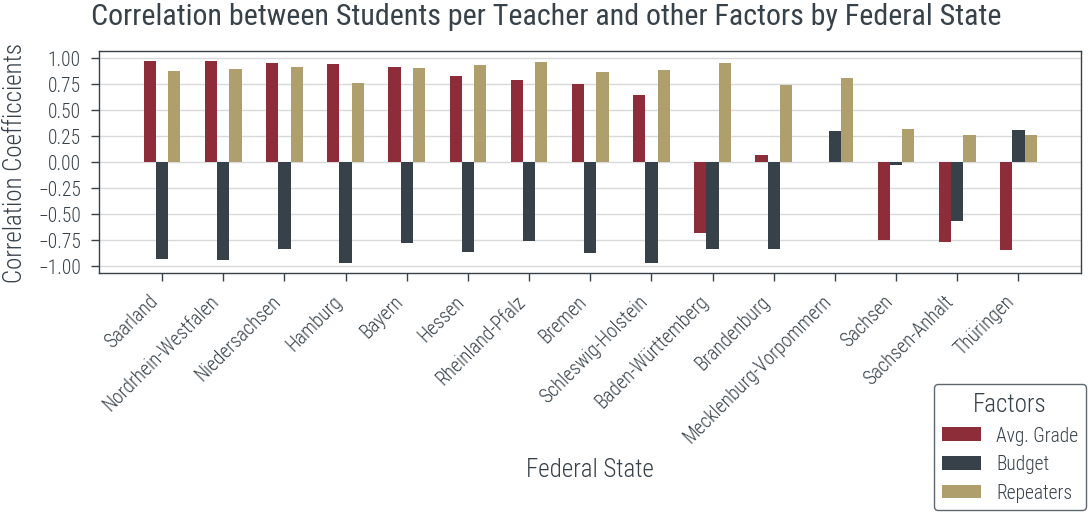

In [87]:
fig, ax = plt.subplots(1,  1)

# Define the number of bars and their positions
num_bars = 3
bar_width = 0.2
positions = np.arange(len(result["state"]))

# Create the bars
ax.bar(positions - bar_width,
       result["Avg. Grade"], width=bar_width, label="Avg. Grade")
ax.bar(positions, result["Budget"], width=bar_width, label="Budget")
ax.bar(positions + bar_width,
       result["Repeaters"], width=bar_width, label="Repeaters")

# Set the x-ticks to be the middle of the bars
ax.set_xticks(positions)
ax.set_ylabel("Correlation Coefficcients")
ax.set_xlabel("Federal State")
ax.set_xticklabels(result["state"], rotation=45, ha='right')
ax.legend(title="Factors", bbox_to_anchor=(
    0.85, -0.5), loc='upper left', borderaxespad=0.)
ax.grid(axis="y")
ax.set_yticks(np.arange(-1, 1.1, 0.25))

fig.suptitle(
    "Correlation between Students per Teacher and other Factors by Federal State")
plt.show()